In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import math

# matplotlit and seaborn for visualizations
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

sns.set_style("darkgrid")
# memory management
import gc
import os
# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

df = pd.read_csv("dataset2.csv")
# import mglearn
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import LabelEncoder

In [3]:
X = df[['트리글리세라이드', '감마지티피', '혈색소', '허리둘레']].copy()
y = df[['당뇨여부']].copy()
X

,트리글리세라이드,감마지티피,혈색소,허리둘레
0,92.0,40.0,17.1,90.0
1,121.0,27.0,15.8,89.0
2,104.0,68.0,15.8,91.0
3,106.0,18.0,17.6,91.0
4,104.0,25.0,13.8,80.0
...,...,...,...,...
1180115,85.0,78.0,15.2,84.0
1180116,139.0,15.0,15.9,77.0
1180117,122.0,23.0,12.4,83.0
1180118,173.0,19.0,12.9,84.0


## 비당뇨 : 당뇨 = 10 : 8

In [4]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy=0.8)
X_rus, y_rus = rus.fit_resample(X, y)


In [5]:
print(len(X_rus))
print(len(y_rus))
print(np.sum(y_rus))

104802
104802
당뇨여부    46579.0
dtype: float64


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus.values,stratify = y_rus, random_state=3, test_size=0.2)
from lightgbm import LGBMClassifier, plot_importance
from sklearn.preprocessing import StandardScaler, RobustScaler
sc = RobustScaler()
x_train = sc.fit_transform(X_train)
x_test = sc.transform(X_test)
lgb = LGBMClassifier(n_estimators=400)
evals = [(x_test, y_test)]

In [7]:
# lgb.fit(x_train, y_train, early_stopping_rounds=100, eval_metric="logloss",eval_set=evals, verbose=True)
lgb.fit(x_train, y_train, eval_metric="logloss",eval_set=evals, verbose=False)

LGBMClassifier(n_estimators=400)

In [8]:
y_pred = lgb.predict(x_test)

## 정확도

In [9]:
lgb.score(x_test, y_test)

0.6323648680883546

## 예측 결과

In [10]:
print("당뇨로 예측한 데이터 수 :", np.sum(y_pred))
print("실제 당뇨 데이터 수 :", np.sum(y_test))
print("전체 데이터 수 :", len(y_test))

당뇨로 예측한 데이터 수 : 9028.0
실제 당뇨 데이터 수 : 9316.0
전체 데이터 수 : 20961


## TN, FP, FN, TP

In [31]:
from sklearn import metrics
TFPN = metrics.confusion_matrix(y_test, y_pred)

print(TFPN[0][0], TFPN[0][1])
print(TFPN[1][0], TFPN[1][1])
# [[TN,FP], 
#  [FN,TP]]

7936 3709
3997 5319


## TN, FP, FN, TP 검토

In [12]:
y_test = y_test.reshape(-1)

In [13]:
P = sum(y_test)
TP = sum((y_test==1) & (y_pred==1))
TPR = TP/P
FN = sum((y_test==1) & (y_pred==0))
FNR = FN/P
N = sum(y_test==0)
TN = sum((y_test==0) & (y_pred==0))
TNR = TN/N
FP = sum((y_test==0) & (y_pred==1))
FPR = FP/N
print(TN, FP, FN, TP)
print(TPR, FPR)

7936 3709 3997 5319
0.5709531987977673 0.3185057964791756


## 데이터 별 당뇨 분류 확률

In [14]:
y_pred_proba = lgb.predict_proba(x_test)
y_pred_proba

array([[0.45124829, 0.54875171],
       [0.82099013, 0.17900987],
       [0.55313547, 0.44686453],
       ...,
       [0.31962984, 0.68037016],
       [0.88509846, 0.11490154],
       [0.40381413, 0.59618587]])

**[당뇨X 확률, 당뇨 확률]**

In [15]:
pos_proba = y_pred_proba[:,1]

## 데이터 별 당뇨로 예측할 확률

In [16]:
print("pos_proba 최솟값 :", min(pos_proba))
print("pos_proba 최댓값 :", max(pos_proba))

pos_proba 최솟값 : 0.0024841341867878745
pos_proba 최댓값 : 0.9779785286863388


(array([ 270.,  509.,  722.,  822.,  972., 1208., 1431., 1630., 1889.,
        2079., 2231., 2366., 1904., 1375.,  807.,  477.,  169.,   71.,
          26.,    3.]),
 array([0.00248413, 0.05125885, 0.10003357, 0.14880829, 0.19758301,
        0.24635773, 0.29513245, 0.34390717, 0.39268189, 0.44145661,
        0.49023133, 0.53900605, 0.58778077, 0.63655549, 0.68533021,
        0.73410493, 0.78287965, 0.83165437, 0.88042909, 0.92920381,
        0.97797853]),
 <BarContainer object of 20 artists>)

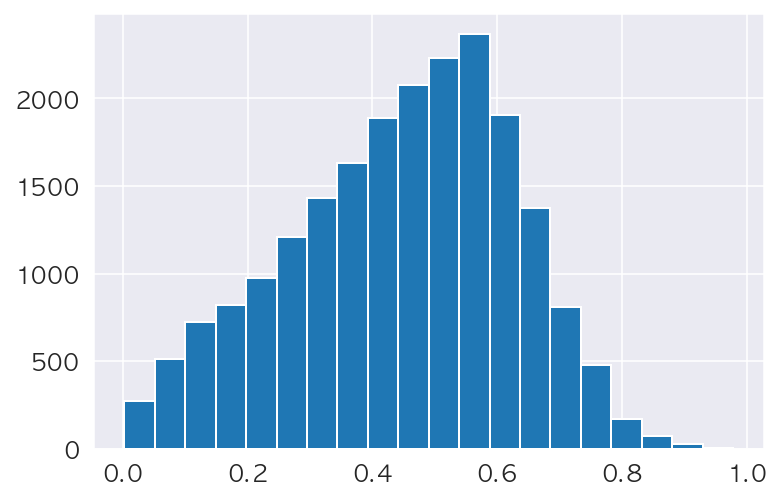

In [17]:
plt.hist(pos_proba, range=(min(pos_proba),max(pos_proba)), bins=20)

## 당뇨 예측 확률과 실제 데이터

In [18]:
pos_sample_pos_proba = pos_proba[y_test==1]
neg_sample_pos_proba = pos_proba[y_test==0]

Text(0, 0.5, 'Number of samples')

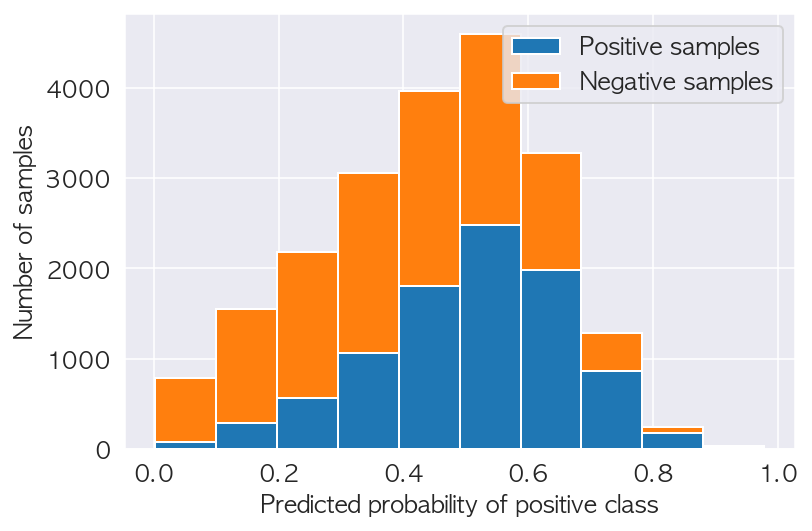

In [19]:
plt.hist([pos_sample_pos_proba, neg_sample_pos_proba], histtype="barstacked")
plt.legend(["Positive samples", "Negative samples"])
plt.xlabel("Predicted probability of positive class")
plt.ylabel("Number of samples")

## ROC Curve

In [20]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)

Text(0.5, 1.0, 'ROC curve')

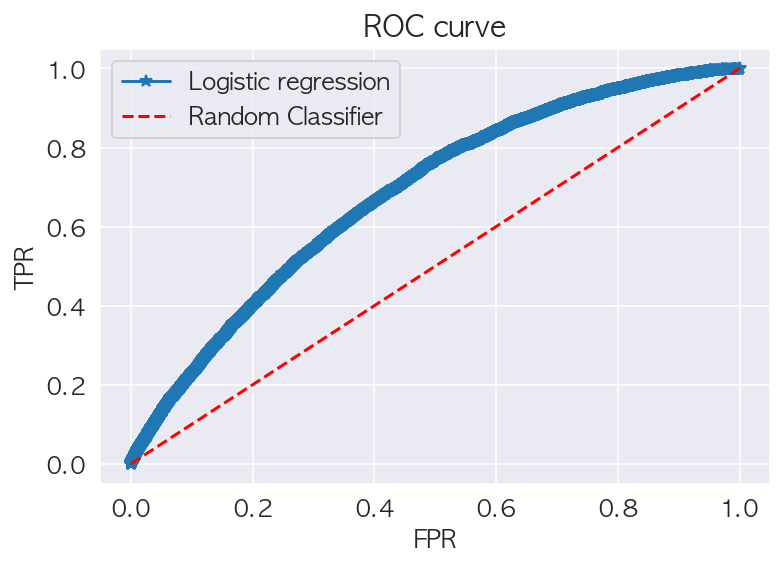

In [21]:
plt.plot(fpr, tpr, '*-')
plt.plot([0,1], [0,1], 'r--')
plt.legend(['Logistic regression', 'Random Classifier'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

## AUC Score

In [22]:
metrics.roc_auc_score(y_test, pos_proba)

0.6822908725847543

## Precision, Recall, Accuracy

In [23]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)
accuracy = (TP+TN)/(TP+FP+TN+FN)
print("precision :",precision)
print("recall :", recall)
print("accuracy :", accuracy)

precision : 0.5891670358883474
recall : 0.5709531987977673
accuracy : 0.6323648680883546


In [24]:
precision2, recall2, thresholds2 = metrics.precision_recall_curve(y_test, pos_proba)

(0.0, 1.0)

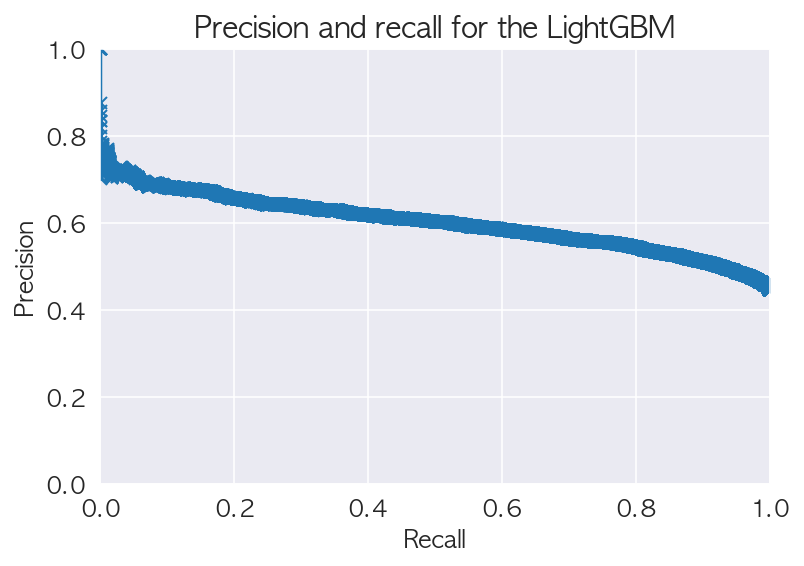

In [25]:
plt.plot(recall2, precision2, '-x')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision and recall for the LightGBM')
plt.xlim([0,1])
plt.ylim([0,1])

In [26]:
metrics.auc(recall2, precision2)

0.5996892457152114

In [27]:
f1 = (precision*recall*2)/(precision+recall)
print(f1)

0.5799171391190581


In [34]:
max_precision = 0
max_recall = 0
max_f1 = 0
max_accuracy = 0
precision_state, recall_state, f1_state, accuracy_state = 0,0,0,0

In [39]:
for i in range(1,11):
    rus = RandomUnderSampler(random_state=i, sampling_strategy=0.8)
    X_rus, y_rus = rus.fit_resample(X, y)
    for j in range(1,11):
        X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus.values,stratify = y_rus, random_state=j, test_size=0.2)
        sc = RobustScaler()
        x_train = sc.fit_transform(X_train)
        x_test = sc.transform(X_test)
        lgb = LGBMClassifier(n_estimators=400)
        evals = [(x_test, y_test)]
        lgb.fit(x_train, y_train, eval_metric="logloss",eval_set=evals, verbose=False)
        y_pred = lgb.predict(x_test)
        TFPN = metrics.confusion_matrix(y_test, y_pred)
        TN = TFPN[0][0]
        FP = TFPN[0][1]
        FN = TFPN[1][0]
        TP = TFPN[1][1]
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        accuracy = (TP+TN)/(TP+FP+TN+FN)
        f1 = (precision*recall*2)/(precision+recall)
        # [[TN,FP], 
        #  [FN,TP]]
        if(precision > max_precision):
            max_precision = precision
            precision_state = (i,j)
        if(recall > max_recall):
            max_recall = recall
            recall_state = (i,j)
        if(accuracy > max_accuracy):
            max_accuracy = accuracy
            accuracy_state = (i,j)
        if(f1 > max_f1):
            max_f1 = f1
            f1_state = (i,j)


In [42]:
print("precision 최댓값 :", max_precision, "[",precision_state,"]")
print("recall 최댓값 :", max_recall, "[",recall_state,"]")
print("accuracy 최댓값 :", max_accuracy, "[",accuracy_state,"]")
print("f1 최댓값 :", max_f1, "[",f1_state,"]")

precision 최댓값 : 0.6036751361161524 [ (4, 35) ]
recall 최댓값 : 0.5871618720480893 [ (6, 5) ]
accuracy 최댓값 : 0.6427651352511807 [ (4, 35) ]
f1 최댓값 : 0.5903269386652256 [ (6, 7) ]
